In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

def get_cols_inf(df):
    """
    Returns a list of column names that contain positive or negative infinity.
    """
    return df.columns[np.isinf(df.values).any(axis=0)].tolist()

def get_cols_zerostd(df):
    """
    Returns a list of column names with zero standard deviation (excluding NaNs).
    """
    nunique_non_nan = df.nunique(dropna=True)
    return nunique_non_nan[nunique_non_nan <= 1].index.tolist()

def get_nan_columns(df):
    """
    Returns a list of column names that contain NaN values.
    """
    return df.columns[df.isna().any()].tolist()

def plot_actual_vs_pred(y_train, y_test, y_pred, figsize=(15, 5)):
    """
    Plots actual train, test and predicted test values on a time series plot.
    Assumes all inputs are pandas Series with datetime index.
    """
    # Rename for clarity
    df_y_train = pd.DataFrame(y_train).reset_index().rename(columns={'label': "Train"})
    df_y_test = pd.DataFrame(y_test).reset_index().rename(columns={'label': "Test"})
    df_y_pred = pd.DataFrame(y_pred, index=y_test.index).reset_index().rename(columns={ 0: "Predicted"})
    # Create a combined DataFrame (aligns on index)
    df_plot = df_y_train.merge(df_y_test, on="timestamp", how = 'outer').merge(df_y_pred, on="timestamp", how='outer')
    # return df_plot
    # Plot
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(data=df_plot, x='timestamp', y='Train', label='Train', ax=ax)
    sns.lineplot(data=df_plot, x='timestamp', y='Test', label='Test', ax=ax)
    # sns.lineplot(data=df_plot, x='timestamp', y='Predicted', label='Predicted', ax=ax)
    ax.axvline(x=df_y_train['timestamp'].iloc[-1], color='gray', linestyle='--', label='Train/Test Split')
    ax.set_xlabel("Timestamp")
    ax.set_title("Actual vs Predicted Time Series")
    ax.set_ylabel("Value")
    ax.legend(loc="best")
    plt.show()

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on the test set and prints the results.
    """
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_corr = pearsonr(y_test, y_pred)[0]
    
    print(f"""
    Model: {model.__class__.__name__}
    Best Hyperparameters: {model.get_params()}
    """)
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test Pearson Correlation: {test_corr:.4f}")
    
    return y_pred

# Tree Models 4 - Random Forest: Efficiency Optimization

- Filter Features first based on random forest

# Functions

## Preprocessing / Feature Engineering

In [2]:
def preprocess_train(train, columns_to_drop=[]):
    df = train.copy()
    
    #### Preprocessing
    # Identify once at the start
    cols_inf = get_cols_inf(df)
    print("Columns with infinite values:", cols_inf)
    cols_nan = get_nan_columns(df)
    print("Columns with NaN values:", cols_nan)
    cols_zerostd = get_cols_zerostd(df)
    print("Columns with zero standard deviation:", cols_zerostd)
    # Drop all at once
    cols_to_drop = set(cols_inf) | set(cols_nan) | set(cols_zerostd)

    df = df.drop(columns=cols_to_drop)

    #### Feature Engineering

    df.loc[:, 'bidask_ratio'] = df['bid_qty'] / df['ask_qty']
    df.loc[:, 'buysell_ratio'] = np.where(df['volume'] == 0, 0, df['buy_qty'] / df['sell_qty'])
    df.loc[:, 'liqnorm_buysellratio'] = np.where(df['volume'] == 0, 0, (df['buy_qty'] + df['sell_qty']) / df['volume'] )
    df.loc[:, 'orderflow_imbalance'] = np.where(df['volume'] == 0, 0, (df['buy_qty'] - df['sell_qty']) / (df['buy_qty'] + df['sell_qty']))

    # df.loc[:, 'buysell_ratio_shift1'] = df['buysell_ratio'].shift(-1)

    df.loc[:, 'bidask_delta'] = df['bid_qty'] - df['ask_qty']
    df.loc[:, 'buysell_delta'] = df['buy_qty'] - df['sell_qty']

    df.loc[:, 'buysell_size'] = df['buy_qty'] + df['sell_qty']
    df.loc[:, 'bidask_size'] = df['bid_qty'] + df['ask_qty']


    # Final Drop
    df = df.drop(columns=columns_to_drop)
    df = df.sort_index(ascending=True)
    return df

## Data Splitting

1. `sklearn_timeseries_split` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html))
   1. expanding window, rolling forward
2. `sklearn_traintest_split`
   1. fixed window
3. `walkforward_split`
   1. fixed window, rolling forward

In [3]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

def sklearn_timeseries_split(X, n_splits=5, **kwargs):
    tscv = TimeSeriesSplit(n_splits=n_splits, **kwargs)
    for train_idx, test_idx in tscv.split(X):
        yield train_idx, test_idx

def sklearn_traintest_split(X, y, test_size=0.2, **kwargs):
    return train_test_split(X, y, test_size=test_size, **kwargs)

def walkforward_split(X, initial_train_size, test_size, step_size=1):
    """
    Generator for walk-forward validation splits.

    Parameters:
    - X: pandas DataFrame or Series (indexed by time)
    - initial_train_size: int, number of initial observations for training
    - test_size: int, number of observations in each test fold
    - step_size: int, how much the train/test window shifts per iteration

    Yields:
    - (train_index, test_index): tuple of numpy arrays
    """
    n = len(X)
    train_start = 0

    for train_end in range(initial_train_size, n - test_size + 1, step_size):
        test_start = train_end
        test_end = test_start + test_size

        train_index = np.arange(train_start, train_end)
        test_index = np.arange(test_start, test_end)

        yield train_index, test_index

# Process Data

In [4]:
data = pd.read_parquet('kaggle/data/train.parquet')
# data = pd.read_parquet("/kaggle/input/drw-crypto-market-prediction/train.parquet")
y = data['label']
X = preprocess_train(data, columns_to_drop=['label', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty'])
X

Columns with infinite values: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717']
Columns with NaN values: []
Columns with zero standard deviation: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872']


,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,0.027359,0.035780,0.068219,1.034825,...,0.159183,0.530636,1.814006,3.921505,1.0,0.593620,6.858,131.421,221.389,23.708
2023-03-01 00:01:00,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,...,0.158963,0.530269,16.519692,1.633316,1.0,0.240501,36.254,203.896,847.796,40.926
2023-03-01 00:02:00,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,...,0.158744,0.529901,0.007336,1.167619,1.0,0.077329,-59.808,22.858,295.596,60.692
2023-03-01 00:03:00,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,...,0.158524,0.529534,0.231490,2.686731,1.0,0.457514,-16.151,210.779,460.705,25.881
2023-03-01 00:04:00,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,...,0.158304,0.529167,7.869603,2.216115,1.0,0.378132,23.707,54.004,142.818,30.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:55:00,94.388,0.020155,0.076565,0.228994,0.288856,0.151634,0.108347,0.088073,0.073729,0.071211,...,0.136494,0.243172,0.611756,0.705263,1.0,-0.172840,-2.642,-16.314,94.388,10.968
2024-02-29 23:56:00,177.372,0.016262,0.062527,0.214072,0.276463,0.146521,0.104164,0.084063,0.069788,0.024066,...,0.136305,0.243004,0.564317,1.640604,1.0,0.242597,-1.768,43.030,177.372,6.348
2024-02-29 23:57:00,101.252,0.045407,0.109834,0.263577,0.329266,0.174214,0.132940,0.113052,0.098865,-0.057370,...,0.136117,0.242836,1.438736,2.292427,1.0,0.392545,1.597,39.746,101.252,8.877


# Model Training

## 1 Data Split

In [5]:
X_train, X_test, y_train, y_test = sklearn_traintest_split(X, y, test_size=0.3, shuffle=False)
X_train

,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,0.027359,0.035780,0.068219,1.034825,...,0.159183,0.530636,1.814006,3.921505,1.0,0.593620,6.858,131.421,221.389,23.708
2023-03-01 00:01:00,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,...,0.158963,0.530269,16.519692,1.633316,1.0,0.240501,36.254,203.896,847.796,40.926
2023-03-01 00:02:00,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,...,0.158744,0.529901,0.007336,1.167619,1.0,0.077329,-59.808,22.858,295.596,60.692
2023-03-01 00:03:00,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,...,0.158524,0.529534,0.231490,2.686731,1.0,0.457514,-16.151,210.779,460.705,25.881
2023-03-01 00:04:00,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,...,0.158304,0.529167,7.869603,2.216115,1.0,0.378132,23.707,54.004,142.818,30.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12 05:25:00,42.613,-0.316648,0.096335,0.177395,0.094867,-0.032564,-0.240218,-0.338348,-0.372513,-0.248211,...,1.469788,2.338208,1.211526,0.184945,1.0,-0.687842,2.705,-29.311,42.613,28.281
2023-11-12 05:26:00,25.050,-0.246827,0.214523,0.306808,0.230663,0.036948,-0.169926,-0.268156,-0.302483,-0.228369,...,1.469946,2.338784,26.653924,1.087326,1.0,0.041836,12.750,1.048,25.050,13.744
2023-11-12 05:27:00,34.009,-0.301947,0.094804,0.190229,0.118450,-0.018021,-0.224422,-0.322827,-0.357354,-0.267332,...,1.470105,2.339359,2.535714,5.058970,1.0,0.669911,5.246,22.783,34.009,12.078


In [6]:
params_split = {
    "ts1": {
        "splitter_func": sklearn_timeseries_split,
        "splitter_args": {"n_splits": 5}
    },
    # "ts2": {
    #     "splitter_func": sklearn_timeseries_split,
    #     "splitter_args": {"n_splits": 10}
    # },
    # "wf1": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 500,
    #         "test_size": 100,
    #         "step_size": 100
    #     }
    # },
    # "wf2": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 1000,
    #         "test_size": 200,
    #         "step_size": 200
    #     }
    # }
}

In [7]:
# # Data 1
# start = pd.Timestamp('2023-03-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# # Data 2
# start = pd.Timestamp('2023-06-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# # Data 3
# start = pd.Timestamp('2023-09-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# Data 4
start = pd.Timestamp('2023-12-01 00:00:00')
end = pd.Timestamp('2024-02-29 23:59:00')

# Data 4
start = pd.Timestamp('2024-02-01 00:00:00')
end = pd.Timestamp('2024-02-29 23:59:00')

X_period = X[(X.index >= start) & (X.index <= end)]
y_period = y[(X.index >= start) & (X.index <= end)]
X_period.shape

(41737, 872)

## 2 Models

In [8]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.metrics import mean_squared_error

##### Random Forest

# 3. Define the base estimator and the search space
base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_space = {
    'n_estimators':    Integer(50, 500),
    'max_depth':       Integer(5, 50),
    'min_samples_leaf': Integer(1, 10),
    'max_features':    Categorical(['sqrt', 'log2', 0.1, 0.3, 0.5, 1.0]),
    # Replace 'mse' → 'squared_error'; 'mae' → 'absolute_error'
    'criterion':       Categorical(['squared_error', 'absolute_error'])
}

##### XGBoost

# base_xgb = XGBRegressor(random_state=42, n_jobs=-1)
base_xgb = XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    random_state=42,
)

xgb_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'gamma': Real(0, 5)
}

##### LightGBM

# base_lgb = LGBMRegressor(random_state=42, n_jobs=-1)
base_lgb = LGBMRegressor(
    device='gpu',
    gpu_platform_id=0,   # usually 0 if you have a single GPU
    gpu_device_id=0,
    random_state=42,
)

lgb_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'num_leaves': Integer(20, 150),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(0, 5),
    'reg_lambda': Real(0, 5)
}
# opt_lgb = BayesSearchCV(base_lgb, lgb_space, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
# opt_lgb.fit(X_train, y_train)

##### CatBoost

# # base_cat = CatBoostRegressor(random_state=42, verbose=0)
base_cat = CatBoostRegressor(
    task_type='GPU',
    devices='0',        # which GPU; use ‘0’ if you have a single GPU
    random_state=42,
    verbose=0,
)

cat_space = {
    'iterations': Integer(50, 500),
    'depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'l2_leaf_reg': Real(1, 10),
    'bagging_temperature': Real(0, 1)
}
# opt_cat = BayesSearchCV(base_cat, cat_space, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
# opt_cat.fit(X_train, y_train)

##### Gradient Boosting

base_gb = GradientBoostingRegressor(random_state=42)
gb_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'min_samples_leaf': Integer(1, 10)
}
# opt_gb = BayesSearchCV(base_gb, gb_space, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
# opt_gb.fit(X_train, y_train)

## 3 Training

In [ ]:
X_train, X_test, y_train, y_test = sklearn_traintest_split(X=X_period, y=y_period, test_size=0.5, shuffle=False)
X_train

,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-02-01 00:00:00,94.421,0.115107,0.474843,0.569143,0.525292,0.186077,0.117180,0.100912,0.111818,0.378102,...,0.138154,0.319480,1.055678,0.820725,1.0,-0.098463,0.202,-9.297,94.421,7.458
2024-02-01 00:01:00,516.998,-0.110973,0.020622,0.113210,0.071934,-0.039672,-0.108598,-0.124994,-0.114182,-0.090815,...,0.137963,0.319259,24.410053,4.165589,1.0,0.612822,8.849,316.828,516.998,9.605
2024-02-01 00:02:00,161.796,-0.117109,0.007591,0.097682,0.058684,-0.045429,-0.114416,-0.130948,-0.120235,-0.146696,...,0.137772,0.319038,17.239506,1.142000,1.0,0.066293,6.577,10.726,161.796,7.387
2024-02-01 00:03:00,296.458,-0.289486,-0.306512,-0.239102,-0.281380,-0.216006,-0.285998,-0.302904,-0.292408,-0.160262,...,0.137582,0.318817,0.175398,2.300983,1.0,0.394120,-2.849,116.840,296.458,4.061
2024-02-01 00:04:00,116.111,-0.203522,-0.122349,-0.065007,-0.107658,-0.128967,-0.199480,-0.216639,-0.206301,0.155547,...,0.137391,0.318596,0.177089,0.474706,1.0,-0.356202,-5.948,-41.359,116.111,8.508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-21 07:12:00,246.328,0.433092,-1.333297,-1.368820,-1.175475,-0.406817,0.054442,0.269666,0.358804,0.584759,...,0.107594,0.478685,1.932480,2.888243,1.0,0.485629,3.425,119.624,246.328,10.771
2024-02-21 07:13:00,125.318,0.502460,-1.085964,-1.190404,-1.019743,-0.334661,0.123468,0.338564,0.427875,0.595196,...,0.107445,0.478353,2.113905,1.102087,1.0,0.048564,2.171,6.086,125.318,6.069
2024-02-21 07:14:00,130.303,0.466361,-1.052875,-1.221873,-1.074040,-0.367695,0.087127,0.302045,0.391505,0.579696,...,0.107299,0.478023,2.394570,1.902718,1.0,0.310991,4.623,40.523,130.303,11.253


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

def pearson_r(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

correlation_scorer = make_scorer(pearson_r, greater_is_better=True)

rf_space = {
    'n_estimators':    Integer(100, 300),
    'max_depth':       Integer(10, 30),
    'min_samples_leaf': Integer(2, 5),
    'max_features':    Categorical(['sqrt', 0.3, 0.5]),
    # Replace 'mse' → 'squared_error'; 'mae' → 'absolute_error'
    'criterion':       Categorical(['squared_error'])
}

n_iter = 10  # Number of iterations for Bayesian optimization
cv = TimeSeriesSplit(n_splits=2)
# scoring = 'neg_mean_squared_error'  # Scoring metric

# opt_rf = BayesSearchCV(
#     estimator=base_rf,
#     search_spaces=rf_space,
#     n_iter=10,
#     cv=2,
#     scoring=correlation_scorer,
#     refit=True,            # <-- do not pass the scorer here
#     random_state=42,
#     n_jobs=-1,
#     verbose=2
# )
# opt_rf.fit(X_train, y_train)
# best_params = opt_rf.best_params_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END criterion=squared_error, max_depth=25, max_features=0.5, min_samples_leaf=3, n_estimators=234; total time= 3.1min
[CV] END criterion=squared_error, max_depth=25, max_features=0.5, min_samples_leaf=3, n_estimators=234; total time= 3.7min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END criterion=squared_error, max_depth=28, max_features=sqrt, min_samples_leaf=5, n_estimators=273; total time=  16.7s
[CV] END criterion=squared_error, max_depth=28, max_features=sqrt, min_samples_leaf=5, n_estimators=273; total time=  18.0s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END criterion=squared_error, max_depth=28, max_features=sqrt, min_samples_leaf=3, n_estimators=138; total time=   8.2s
[CV] END criterion=squared_error, max_depth=28, max_features=sqrt, min_samples_leaf=3, n_estimators=138; total time=   8.7s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END criterion=squ

BayesSearchCV(cv=2, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
              n_iter=10, n_jobs=-1, random_state=42,
              scoring=make_scorer(pearson_r, response_method='predict'),
              search_spaces={'criterion': Categorical(categories=('squared_error',), prior=None),
                             'max_depth': Integer(low=10, high=30, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 0.3, 0.5), prior=None),
                             'min_samples_leaf': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=300, prior='uniform', transform='normalize')},
              verbose=2)

In [ ]:
best_rf = RandomForestRegressor(
    max_depth=25,
    max_features=0.5,
    min_samples_leaf=3,
    n_estimators=234,
    n_jobs=-1,
    random_state=42,
)
best_rf.fit(X_train, y_train)
best_rf
# y_pred = best_rf.predict(X_test)

RandomForestRegressor(max_depth=25, max_features=0.5, min_samples_leaf=3,
                      n_estimators=234, n_jobs=-1, random_state=42)

### 4 Optimization Results

1.  ```scoring = 'neg_mean_squared_error'```
    ```
    OrderedDict([('criterion', 'squared_error'),
                ('max_depth', 28),
                ('max_features', 'sqrt'),
                ('min_samples_leaf', 3),
                ('n_estimators', 138)])
    Test MSE: 2.2229
    Test Pearson Correlation: -0.1551
    ```
2. ```scoring = correlation_scorer```
    ```
    OrderedDict([('criterion', 'squared_error'),
             ('max_depth', 25),
             ('max_features', 0.5),
             ('min_samples_leaf', 3),
             ('n_estimators', 234)])
    ```


    Model: RandomForestRegressor
    Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 25, 'max_features': 0.5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 234, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
    
Test MSE: 3.7250
Test Pearson Correlation: -0.1671


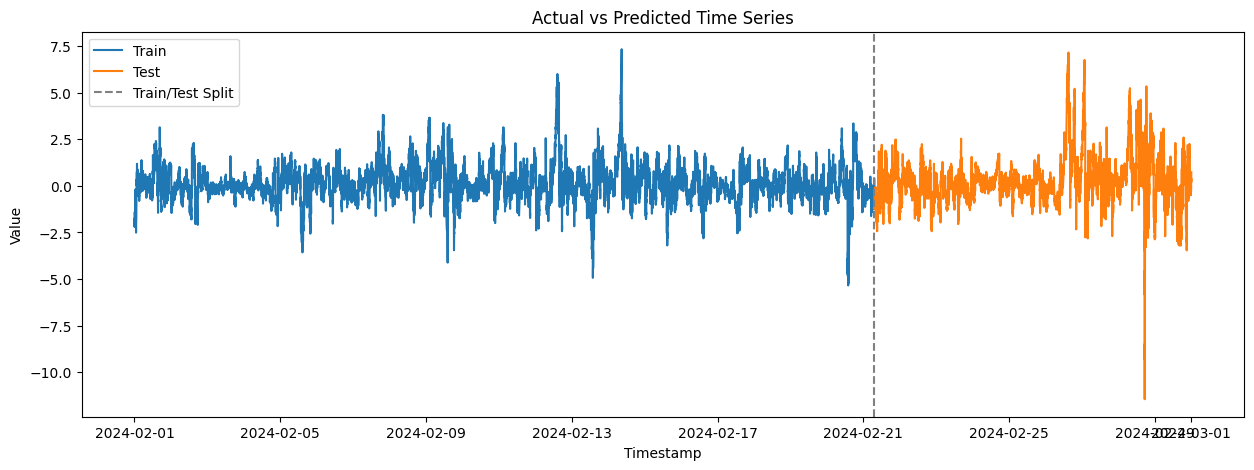

In [24]:
y_pred = evaluate_model(best_rf, X_test, y_test)
plot_actual_vs_pred(y_train, y_test, y_pred, figsize=(15, 5))

# Best Model

In [28]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances

X873                    0.034452
X866                    0.022761
X890                    0.017207
X855                    0.015375
X415                    0.010237
                          ...   
X522                    0.000007
X549                    0.000007
X508                    0.000006
X500                    0.000004
liqnorm_buysellratio    0.000000
Length: 872, dtype: float64

# Feature Importance

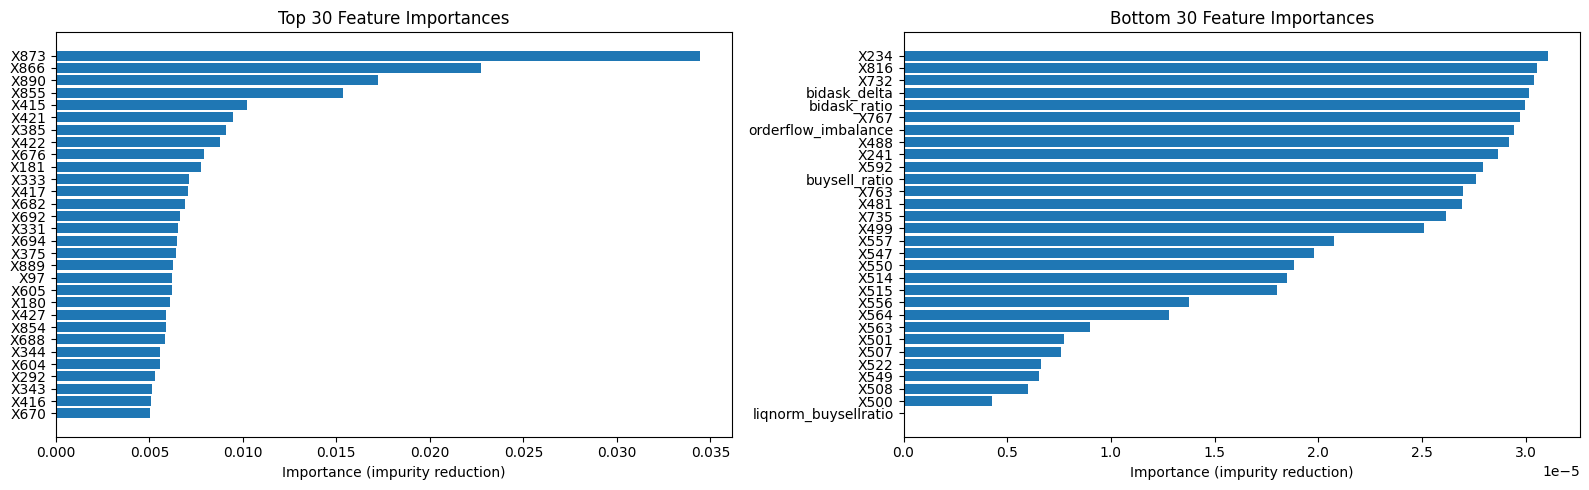

In [29]:
import matplotlib.pyplot as plt

def plot_treebased_importance(
    model: RandomForestRegressor,
    columns: list[str],
    count: int = 10,
    figsize: tuple[int, int] = (16, 10)
) -> None:
    """
    Plot the top `n_features` and bottom `n_features` feature importances 
    from a fitted RandomForestRegressor.

    Parameters
    ----------
    model : RandomForestRegressor
        A fitted RandomForestRegressor instance.
    columns : list[str]
        List of feature names (must match the order used to fit `model`).
    n_features : int, default 10
        Number of top and bottom features to plot.
    figsize : tuple[int, int], default (16, 10)
        Figure size for the combined 1×2 plot.
    """
    # 1. Build a Series of importances, indexed by feature name, sorted descending
    importances = pd.Series(
        data=model.feature_importances_,
        index=columns
    ).sort_values(ascending=False)

    # 2. Select top-n (highest importance) and bottom-n (lowest importance)
    top_n = importances.head(count)
    bottom_n = importances.tail(count)

    # 3. Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 4. Plot top-n (left); invert y-axis so highest importance appears at top
    axes[0].barh(top_n.index, top_n.values)
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {count} Feature Importances")
    axes[0].set_xlabel("Importance (impurity reduction)")

    # 5. Plot bottom-n (right); invert y-axis so lowest importance appears at top
    axes[1].barh(bottom_n.index, bottom_n.values)
    axes[1].invert_yaxis()
    axes[1].set_title(f"Bottom {count} Feature Importances")
    axes[1].set_xlabel("Importance (impurity reduction)")

    plt.tight_layout()
    plt.show()
    return importances

importances = plot_treebased_importance(model=best_rf, columns=X.columns, count=30, figsize=(16, 5))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


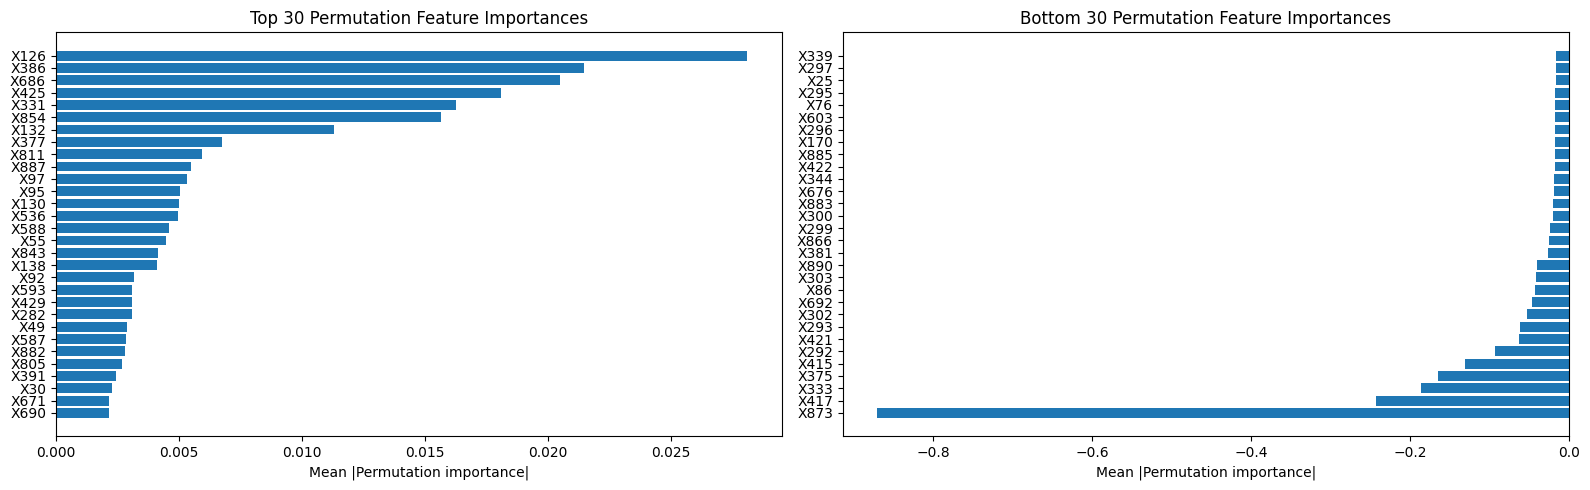

In [30]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(
    model: RandomForestRegressor,
    X_test: pd.DataFrame,
    y_test: pd.Series | np.ndarray,
    random_state: int | None = None,
    count: int = 10,
    n_repeats: int = 5,
    n_jobs: int = -1,
    scoring: str = 'neg_mean_squared_error',
    figsize: tuple[int, int] = (8, 6)
) -> None:
    """
    Compute permutation importances on a fitted RandomForestRegressor quickly 
    by using parallel jobs and fewer repeats, then plot a descending bar chart of mean importance.

    Parameters
    ----------
    model : RandomForestRegressor
        A fitted RandomForestRegressor instance.
    X_test : pd.DataFrame
        Feature matrix for testing.
    y_test : pd.Series or np.ndarray
        True target values corresponding to X_test.
    random_state : int or None, default=None
        Seed for reproducibility (used by permutation_importance).
    n_repeats : int, default=5
        Number of times to permute a feature. Fewer repeats speeds up computation.
    n_jobs : int, default=-1
        Number of parallel jobs for permutation_importance. Set to -1 to use all available cores.
    scoring : str, default='neg_mean_squared_error'
        Scoring metric to evaluate performance after permutation.
    figsize : tuple[int, int], default=(8, 6)
        Figure size for the bar chart.
    """
    # Optionally subsample X_test if it's very large (uncomment if needed)
    # max_samples = 1000
    # if len(X_test) > max_samples:
    #     X_sub = X_test.sample(n=max_samples, random_state=random_state)
    #     y_sub = y_test[X_sub.index]
    # else:
    #     X_sub, y_sub = X_test, y_test

    # Compute permutation importances using parallel jobs
    perm_res = permutation_importance(
        estimator=model,
        X=X_test,
        y=y_test,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
        n_jobs=n_jobs
    )

    importances_mean = pd.Series(perm_res.importances_mean, index=X_test.columns).sort_values(ascending=False)

    # 3. Select top‐`count` and bottom‐`count`
    top_n = importances_mean.head(count)
    bottom_n = importances_mean.tail(count)

    # 4. Create a 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 5. Plot top‐count features on the left (highest at top)
    axes[0].barh(top_n.index, top_n.values)
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {count} Permutation Feature Importances")
    axes[0].set_xlabel("Mean |Permutation importance|")

    # 6. Plot bottom‐count features on the right (lowest at top)
    axes[1].barh(bottom_n.index, bottom_n.values)
    axes[1].invert_yaxis()
    axes[1].set_title(f"Bottom {count} Permutation Feature Importances")
    axes[1].set_xlabel("Mean |Permutation importance|")

    plt.tight_layout()
    plt.show()
    return importances_mean

permutation_importances = plot_permutation_importance(
    model=best_rf,
    X_test=X_test,
    y_test=y_test,
    random_state=42,
    count=30,
    n_repeats=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    figsize=(16, 5)
)

In [ ]:
import shap

def plot_shap_importance(
    X_test: pd.DataFrame,
    model,
    figsize: tuple[int, int] = (12, 6),
    count: int = 10,
) -> None:
    """
    Given a fitted tree‐based model and a test DataFrame X_test, compute TreeSHAP values 
    and plot the top `count` and bottom `count` features by average absolute SHAP value.

    Parameters
    ----------
    X_test : pd.DataFrame
        Test feature matrix (no labels needed for SHAP).
    model : fitted tree‐based estimator
        A fitted model that supports TreeExplainer (e.g., RandomForestRegressor).
    figsize : tuple[int, int], default (12, 6)
        Figure size for the 1×2 plot.
    count : int, default 10
        Number of top and bottom features to display.
    """
    # 1. Compute SHAP values for X_test
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_test)  # shape: (n_test, n_features)

    # 2. Compute mean absolute SHAP value per feature
    mean_abs_shap = pd.Series(
        data=abs(shap_vals).mean(axis=0),
        index=X_test.columns
    ).sort_values(ascending=False)

    # 3. Select top‐`count` and bottom‐`count`
    top_n = mean_abs_shap.head(count)
    bottom_n = mean_abs_shap.tail(count).sort_values(ascending=True)

    # 4. Create a 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 5. Plot top‐count features on the left (highest at top)
    axes[0].barh(top_n.index, top_n.values)
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {count} SHAP Feature Importances")
    axes[0].set_xlabel("Mean |SHAP value|")

    # 6. Plot bottom‐count features on the right (lowest at top)
    axes[1].barh(bottom_n.index, bottom_n.values)
    axes[1].invert_yaxis()
    axes[1].set_title(f"Bottom {count} SHAP Feature Importances")
    axes[1].set_xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()

shap_importance = plot_shap_importance(
    X_test=X_test,
    model=best_rf,
    count=30
)